# Image Enhancement Example

In this Example, we will explore how the colors in the images can be corrected using histogram manipulation techniques [1].

At first, we import libraries such as numpy and matplotlib. Additionally, we import specific functions from the skimage and scipy.stats library.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from skimage import img_as_ubyte
from skimage.color import rgb2gray
from skimage.exposure import histogram, cumulative_distribution
from scipy.stats import cauchy, logistic

Let’s use a nighttime image of the Manila Cathedral in Intramuros, Manila.

Text(0.5, 1.0, 'Manila Cathedral')

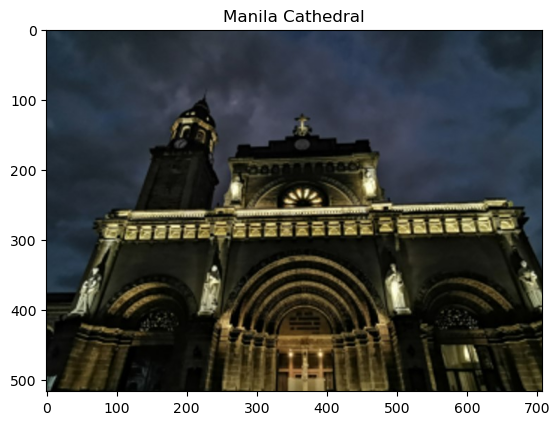

In [2]:
cathedral = imread('cathedral.jpg')
plt.imshow(cathedral)
plt.title('Manila Cathedral')

For starters, let us convert the image to grayscale.

Text(0.5, 1.0, 'Histogram of Pixel Intensity')

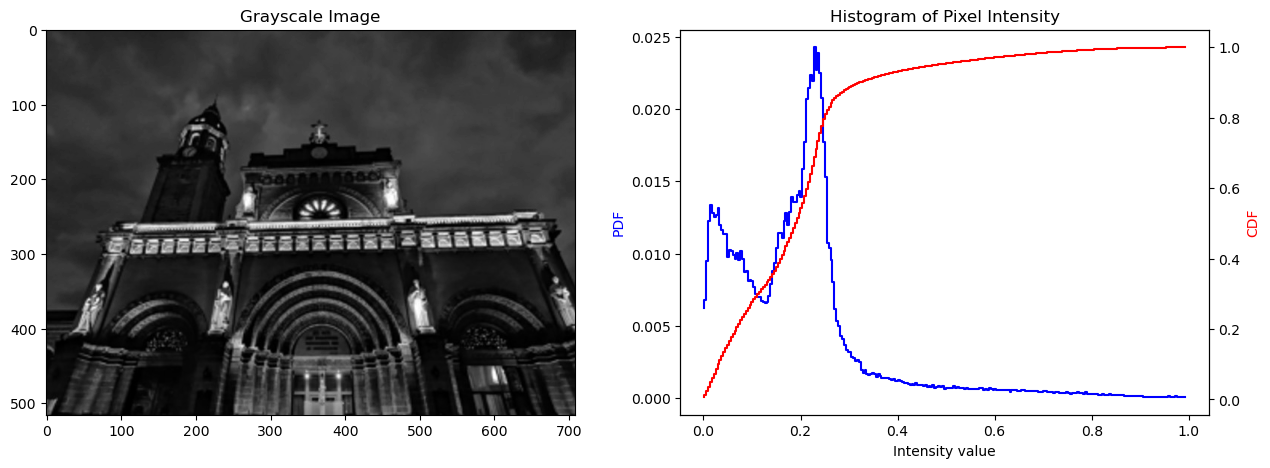

In [3]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
cathedral_gray = rgb2gray(cathedral)
ax[0].imshow(cathedral_gray, cmap='gray')
ax[0].set_title('Grayscale Image')
ax1 = ax[1]
ax2 = ax1.twinx()
freq_h, bins_h = histogram(cathedral_gray)
freq_c, bins_c = cumulative_distribution(cathedral_gray)
ax1.step(bins_h, freq_h*1.0/freq_h.sum(), c='b', label='PDF')
ax2.step(bins_c, freq_c, c='r',  label='CDF')
ax1.set_ylabel('PDF', color='b')
ax2.set_ylabel('CDF', color='r')
ax[1].set_xlabel('Intensity value')
ax[1].set_title('Histogram of Pixel Intensity')

Since the image was taken at nighttime, the features of the image are dim. This is also observed on the histogram of pixel intensity value wherein the PDF is skewed on the lower spectrum.

Since the intensity values of the image are skewed, histogram manipulation can be applied to redistribute the intensity values of the image. The objective of histogram manipulation is to stretch the actual CDF of the image into the new target CDF. By doing so, the intensity values that are skewed to the lower spectrum will be translated to a higher intensity value — thereby lightening the image.

Let’s try to implement this on a grayscale image. We assume that the PDF is a uniform distribution, and the CDF is a linear distribution.

Text(0.5, 1.0, 'Corrected Image in Grayscale')

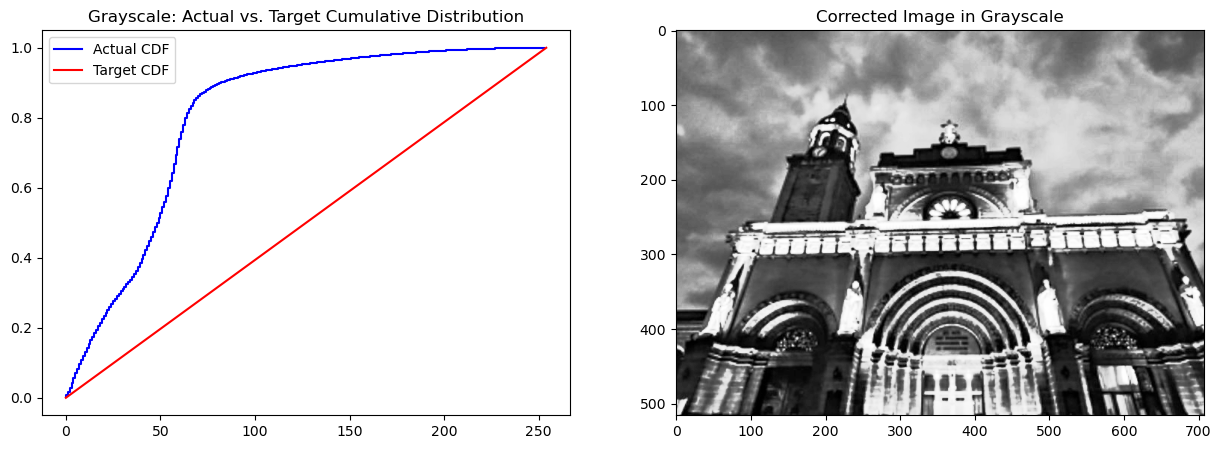

In [4]:
image_intensity = img_as_ubyte(cathedral_gray)
freq, bins = cumulative_distribution(image_intensity)
target_bins = np.arange(255)
target_freq = np.linspace(0, 1, len(target_bins))
new_vals = np.interp(freq, target_freq, target_bins)
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].step(bins, freq, c='b', label='Actual CDF')
ax[0].plot(target_bins, target_freq, c='r', label='Target CDF')
ax[0].legend()
ax[0].set_title('Grayscale: Actual vs. '
                'Target Cumulative Distribution')
ax[1].imshow(new_vals[image_intensity].astype(np.uint8), 
             cmap='gray')
ax[1].set_title('Corrected Image in Grayscale')

By translating the actual CDF to the target CDF, we could lighten the image while still maintaining the key features of the image. Note that this is entirely different from only applying a brightness filter since the brightness filters just increase the intensity values of all pixels in the image by an equal amount. In histogram manipulation, the pixel intensity values can either be increased or decreased depending on the target CDF.

Now, let’s try to implement histogram manipulation in colored images. The procedures are replicable from the grayscale image — however, the difference is that we need to apply histogram manipulation on each of the channels of the image. To simplify the implementation, I have created a function that will do this procedure to the image.

In [5]:
def show_linear_cdf(image, channel, name, ax):
    image_intensity = img_as_ubyte(image[:,:,channel])
    freq, bins = cumulative_distribution(image_intensity)
    target_bins = np.arange(255)
    target_freq = np.linspace(0, 1, len(target_bins))
    ax.step(bins, freq, c='b', label='Actual CDF')
    ax.plot(target_bins, target_freq, c='r', label='Target CDF')
    ax.legend()
    ax.set_title('{} Channel: Actual vs. '
                 'Target Cumulative Distribution'.format(name))
def linear_distribution(image, channel):
    image_intensity = img_as_ubyte(image[:,:,channel])
    freq, bins = cumulative_distribution(image_intensity)
    target_bins = np.arange(255)
    target_freq = np.linspace(0, 1, len(target_bins))
    new_vals = np.interp(freq, target_freq, target_bins)
    return new_vals[image_intensity].astype(np.uint8)

Now, we apply these functions to each channel of the original image.

Text(0.5, 1.0, 'Corrected Image in Blue Channel')

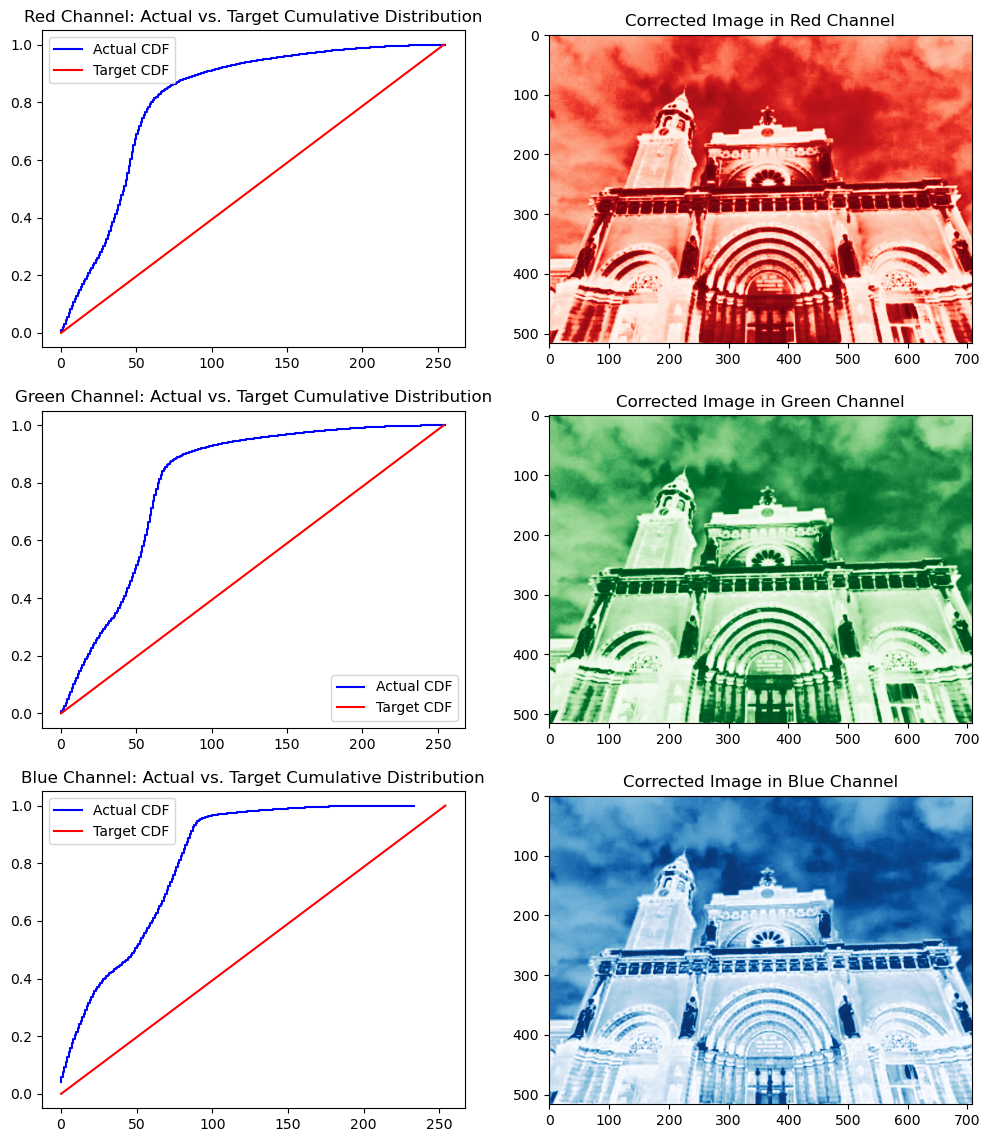

In [6]:
fig, ax = plt.subplots(3,2, figsize=(12,14))
red_channel = linear_distribution(cathedral, 0)
green_channel = linear_distribution(cathedral, 1)
blue_channel = linear_distribution(cathedral, 2)
show_linear_cdf(cathedral, 0, 'Red', ax[0,0])
ax[0,1].imshow(red_channel, cmap='Reds')
ax[0,1].set_title('Corrected Image in Red Channel')
show_linear_cdf(cathedral, 1, 'Green', ax[1,0])
ax[1,1].imshow(green_channel, cmap='Greens')
ax[1,1].set_title('Corrected Image in Green Channel')
show_linear_cdf(cathedral, 2, 'Blue', ax[2,0])
ax[2,1].imshow(blue_channel, cmap='Blues')
ax[2,1].set_title('Corrected Image in Blue Channel')

Notice that all channels almost have identical CDFs. This shows a good distribution of colors in our image — it’s just that the colors are concentrated on the lower intensity value spectrum. Like what we did in the grayscale image, we will also translate the actual CDF of each channel to the target CDF.

After correcting the histogram of each channel, we need to stack these channels together using the numpy stack function. Note that the RGB channels need to be in order when stacked.

Text(0.5, 1.0, 'Transformed Image')

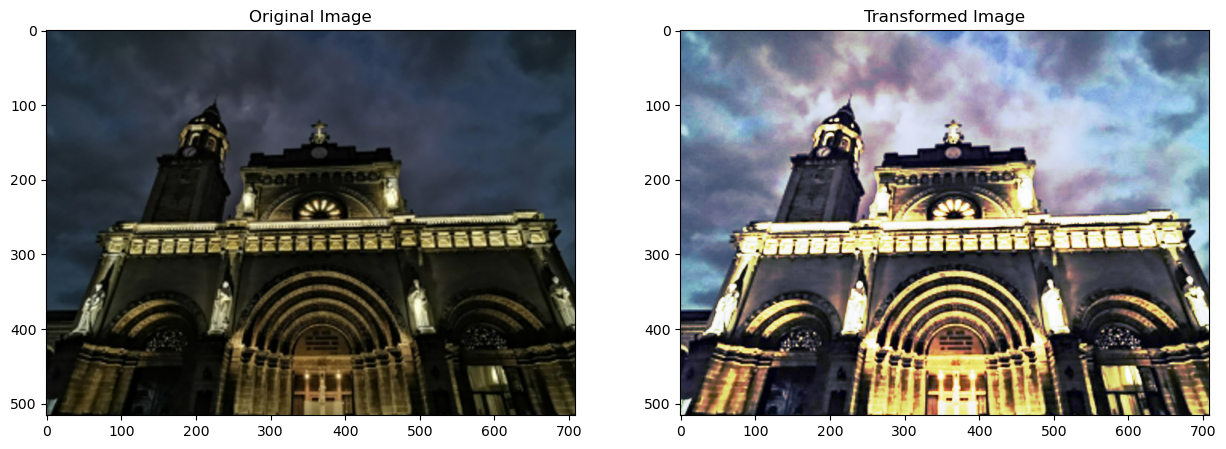

In [7]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].imshow(cathedral)
ax[0].set_title('Original Image')
ax[1].imshow(np.dstack([red_channel, green_channel, blue_channel]))
ax[1].set_title('Transformed Image')

Once all of the channels are stacked, we can see how the transformed image colors differ significantly from the original image. The most interesting thing about histogram manipulation is that different parts of the image will have different degrees of pixel intensity translation. Notice how pixel intensity of the Manila Cathedral walls are changed drastically while those of the Manila Cathedral Bell Tower remained relatively the same.

Now, let’s try to improve this by using other functions as our target CDF. To do this, we will be using the scipy.stats library to import various distributions. I have also created a function to simplify our analysis.

In [8]:
def individual_channel(image, dist, channel):
    im_channel = img_as_ubyte(image[:,:,channel])
    freq, bins = cumulative_distribution(im_channel)
    new_vals = np.interp(freq, dist.cdf(np.arange(0,256)), np.arange(0,256))
    return new_vals[im_channel].astype(np.uint8)

def distribution(image, function, mean, std):
    dist = function(mean, std)
    fig, ax = plt.subplots(1,2, figsize=(15,5))
    
    image_intensity = img_as_ubyte(rgb2gray(image))
    freq, bins = cumulative_distribution(image_intensity)
    ax[0].step(bins, freq, c='b', label='Actual CDF')
    ax[0].plot(dist.cdf(np.arange(0,256)), 
               c='r', label='Target CDF')
    ax[0].legend()
    ax[0].set_title('Actual vs. Target Cumulative Distribution')
    
    red = individual_channel(image, dist, 0)
    green = individual_channel(image, dist, 1)
    blue = individual_channel(image, dist, 2)
    ax[1].imshow(np.dstack((red, green, blue)))
    ax[1].set_title('Transformed Image')
    return ax

Let’s try this using the Cauchy function.

array([<Axes: title={'center': 'Actual vs. Target Cumulative Distribution'}>,
       <Axes: title={'center': 'Transformed Image'}>], dtype=object)

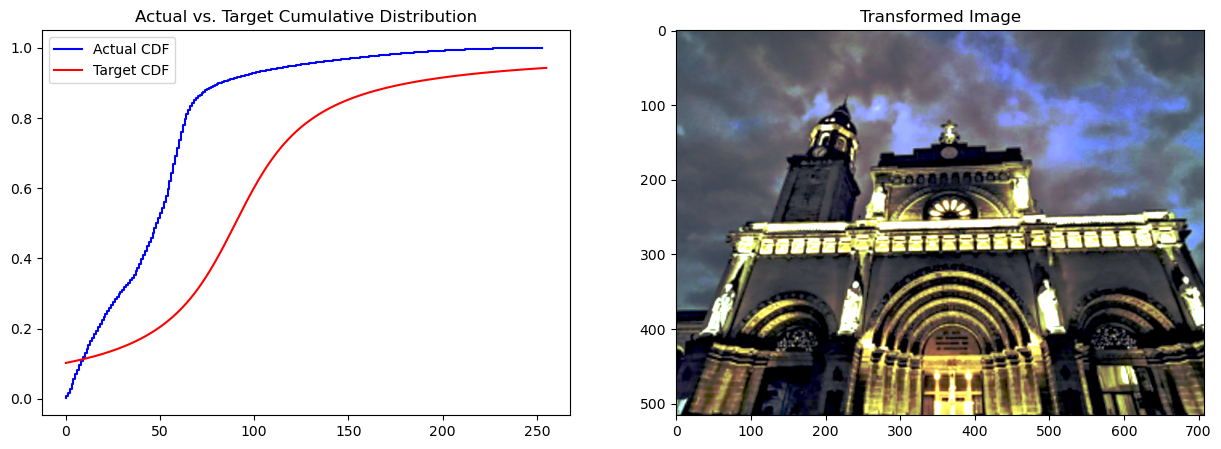

In [9]:
distribution(cathedral, cauchy, 90, 30)

Using a different distribution seemed to have resulted in a more pleasing color scheme. In fact, the arc in the cathedral’s main entrance is better in the logistic distribution than the linear distribution. This is because the translation of the pixel value intensity is less in the logistic distribution than the linear distribution, which can be seen by the distance of the Actual CDF line to the Target CDF line.

Let’s see if we can further improve this using the logistic distribution.

array([<Axes: title={'center': 'Actual vs. Target Cumulative Distribution'}>,
       <Axes: title={'center': 'Transformed Image'}>], dtype=object)

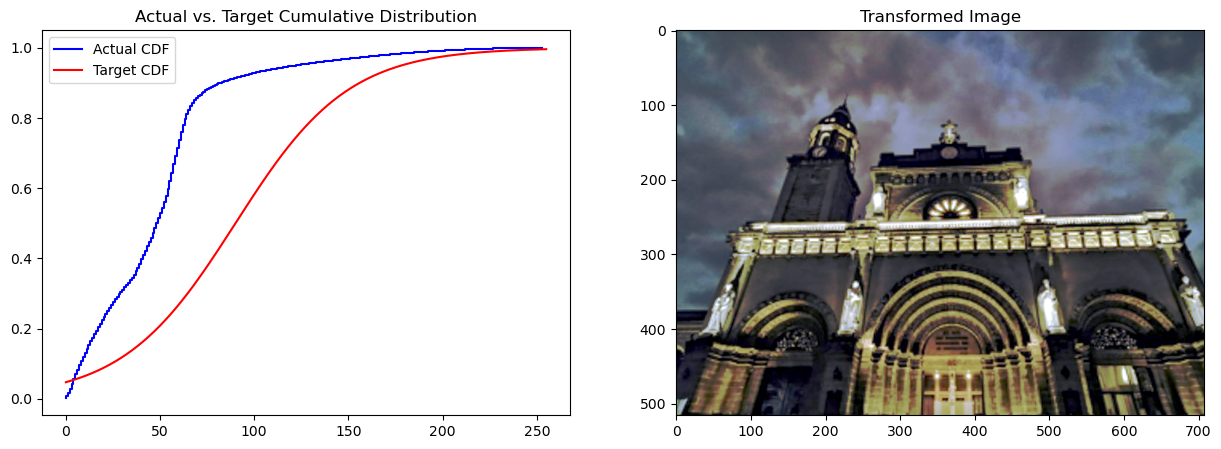

In [10]:
distribution(cathedral, logistic, 90, 30)

Notice how the lights in the doors improved from the linear and Cauchy distribution to the logistic distribution. This is because the upper spectrum of the logistic function is almost coincidental with the original CDF. Thus, all of the dark objects (low pixel intensity values) in the image were translated while the lights (high pixel intensity values) almost remained the same.

Summary


We have explored how to correct the colors in an image using histogram manipulation. Various distribution functions were implemented to see how it can affect the distribution of colors in the resulting image.

Again, we can conclude that there is no “one-size-fits-all” solution in fixing the color intensity of an image. It is the subjective decision to determine which is the best solution that will fit their image processing needs.

More examples:
    
https://scipy-lectures.org/advanced/image_processing/

https://code.tutsplus.com/articles/image-enhancement-in-python--cms-29289

https://www.geeksforgeeks.org/image-enhancement-in-pil/ 

https://developpaper.com/examples-of-python-image-enhancement-processing/

Reference

[1] Jephraim Manansala, "Image Processing with Python: Color Correction using Histogram Manipulation", Jan 28, 2021.